### plotting figures and some stats for the neanderthal predixcan manuscript

#### load libraries, standard info

In [1]:
library(readr)
library(dplyr)
library(ggplot2)
library(fmsb)
library(PheWAS)
#library(karyoploteR)
library(knitr)

abbreviations <- c("ADPS","ESPMC","ABPV","ESPMS","ADRNLG","HRTAA","BRNACC","HRTLV","ARTA","LIVER","ARTC","LUNG","ARTT","MSCSK","BRNCDT","NERVET","BRNCHB","OVARY",
                   "BRNCHA","PNCS","BRNCTX","PTTY","BRNFCTX","PRSTT","BRNHPP","SKINNS","BRNHPT","SKINS","BRNNCC","SMINT","BRNPTM","SPLEEN","BREAST","STMCH","TESTIS",
                   "FIBS","THYROID","CLNS","UTERUS","CLNT","VAGINA","ESPGJ","WHLBLD")
names(abbreviations) <- c("adipose_subcutaneous","esophagus_mucosa","adipose_visceral_omentum","esophagus_muscularis",
        "adrenal_gland","heart_atrial_appendage","anterior_cingulate_cortex","left_ventricle","artery_aorta","liver","artery_coronary",
        "lung","artery_tibial","muscle_skeletal","brain_caudate_basal_ganglia","nerve_tibial","brain_cerebellar_hemisphere","ovary",                                
        "brain_cerebellum","pancreas","brain_cortex","pituitary","brain_frontal_cortex","prostate","brain_hippocampus","skin_nosun_suprapubic","brain_hypothalamus",
        "skin_sun_lower_leg","brain_nucleus_accumbens_basal_ganglia","small_intestine_terminal_ileum","brain_putamen_basal_ganglia",
        "spleen","breast_mammary_tissue","stomach","testis","cells_transformed_fibroblasts","thyroid","colon_sigmoid","uterus",
        "colon_transverse","vagina","esophagus_gastroesophageal_junction","whole_blood")



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: tidyr
Loading required package: parallel


#### plot counts of DR genes per tissue, filtered for Non-Introgressed genes

Parsed with column specification:
cols(
  .default = col_double(),
  gene_id = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  X1 = col_character()
)
Joining, by = "gene_id"


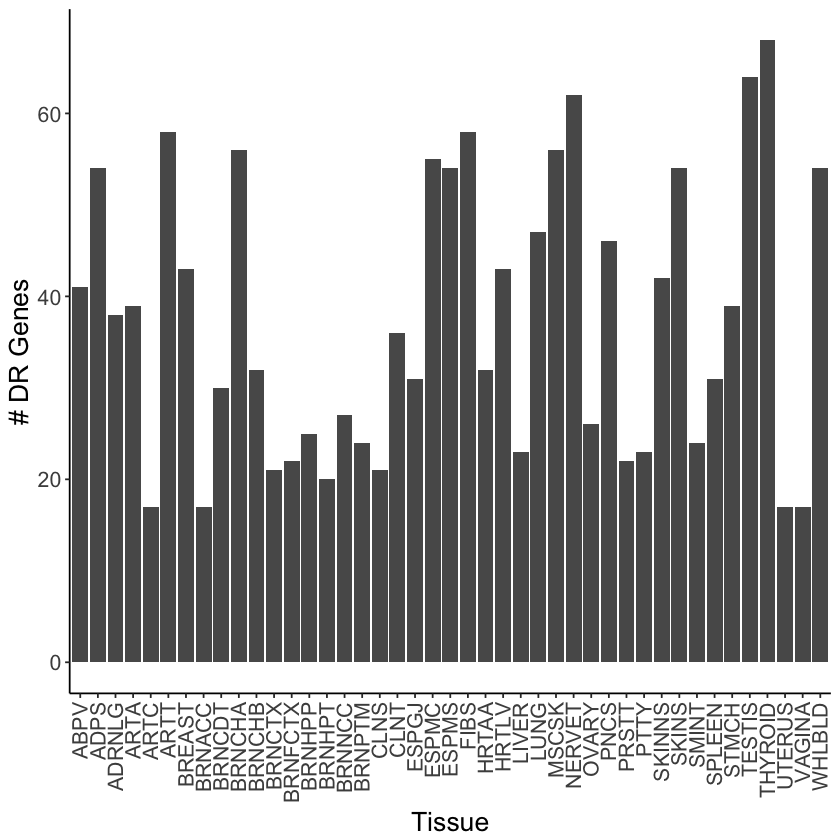

In [4]:
p_file_path <- "data/altai_original_pvalues_2sided.txt"
intro_path <- "data/altai_intro_genes.txt"

p_mat <- read_delim(p_file_path, "\t", escape_double = FALSE, trim_ws = TRUE)
intro <- read_csv(intro_path, col_names = FALSE)
intro$gene_id <- intro$X1
intro$X1 <- NULL
p_mat <- anti_join(p_mat, intro)
counts <- c()
tiss <- c()
for (i in 2:ncol(p_mat)) {
tiss <- c(tiss, names(p_mat[i]))
counts <- c(counts,nrow(p_mat[!is.na(p_mat[,i]) & p_mat[,i] == 0,]))
}
out <- data.frame(num = counts, Tissue = tiss)
for (i in 1:nrow(out)) {
out$abb[i] <- abbreviations[as.character(out$Tissue[i])]
}
ggplot(out, aes(x = abb, y = num)) + geom_bar(stat="identity") + labs(x="Tissue",y="# DR Genes") + 
theme_classic() + theme(text = element_text(size=16), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1))
ggsave('dr_gene_counts.pdf', width=7, height= 5) 

#### raw expression comparisons for non-introgressed genes based on introgression status

Parsed with column specification:
cols(
  X1 = col_character()
)
Parsed with column specification:
cols(
  X1 = col_character()
)
Parsed with column specification:
cols(
  X1 = col_character()
)
Parsed with column specification:
cols(
  .default = col_double(),
  gene_id = col_character()
)
See spec(...) for full column specifications.
Joining, by = "X1"
Warning message:
"Column `X1` joining factor and character vector, coercing into character vector"Joining, by = "X1"
Joining, by = "X1"
Joining, by = "X1"
Joining, by = "gene_id"
Joining, by = "gene_id"
Warning message:
"Column `gene_id` joining character vector and factor, coercing into character vector"

[1] "Desert Mean:"

[1] 0.0002551554

[1] "Desert Max:"

[1] 0.006554611

[1] "Desert Min:"

[1] 0.05430711

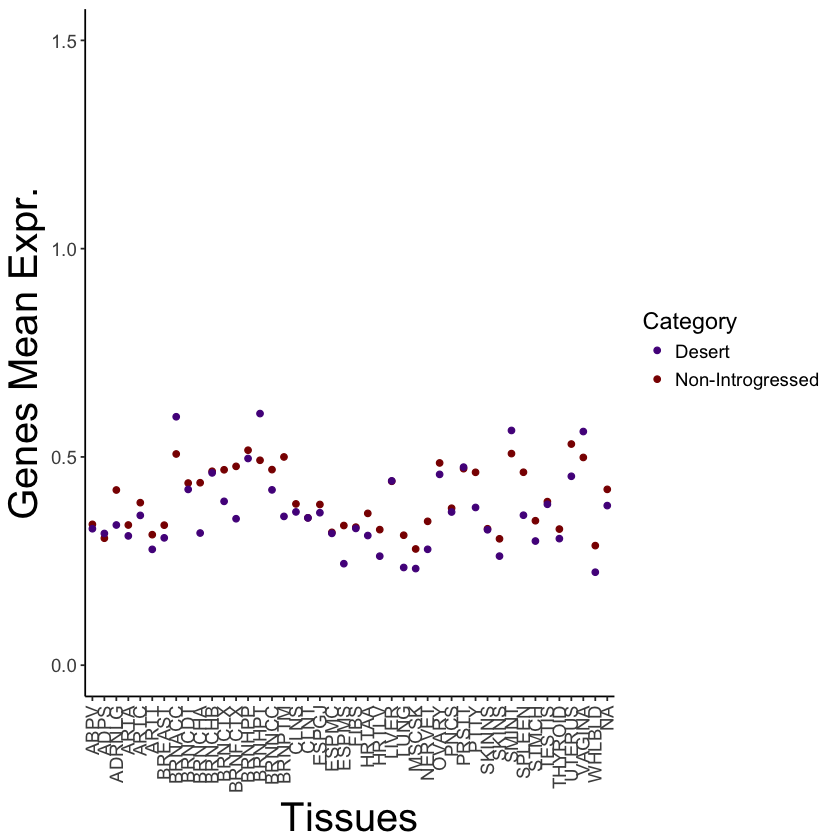

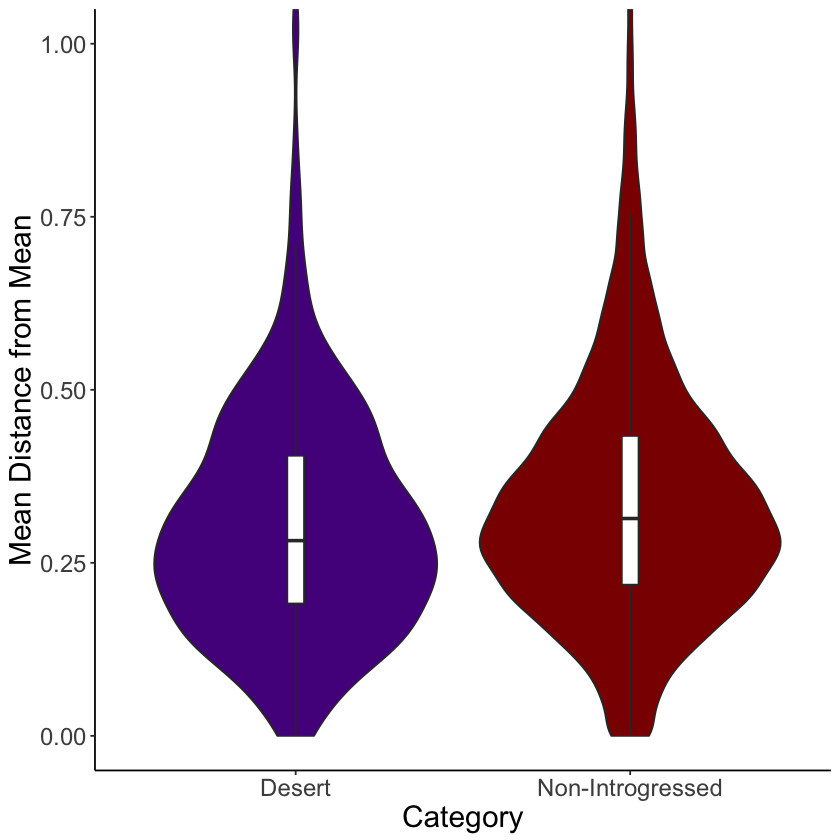

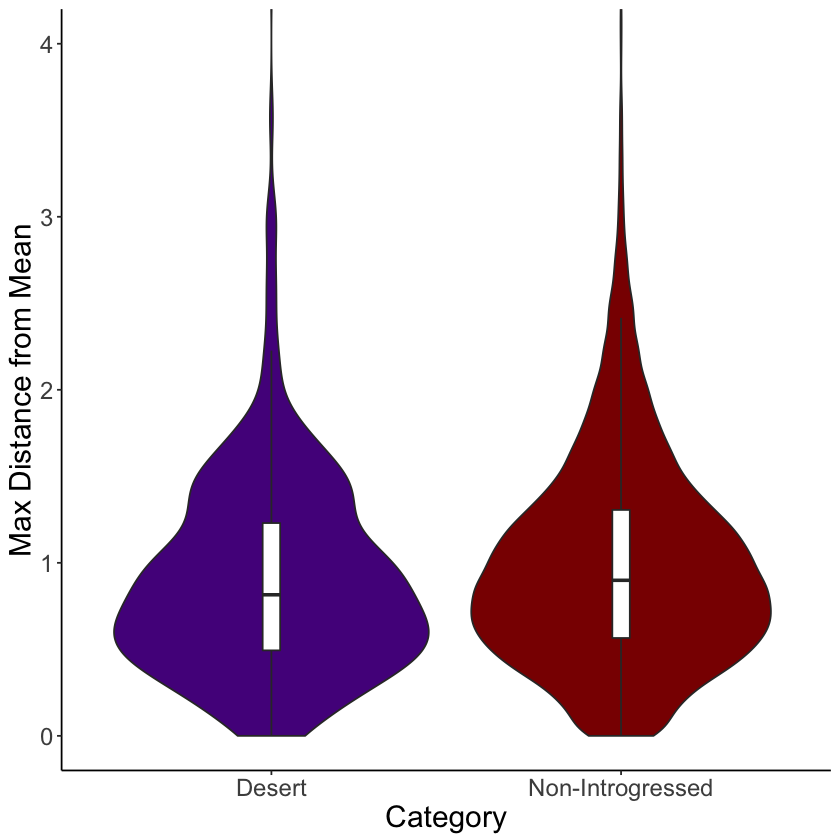

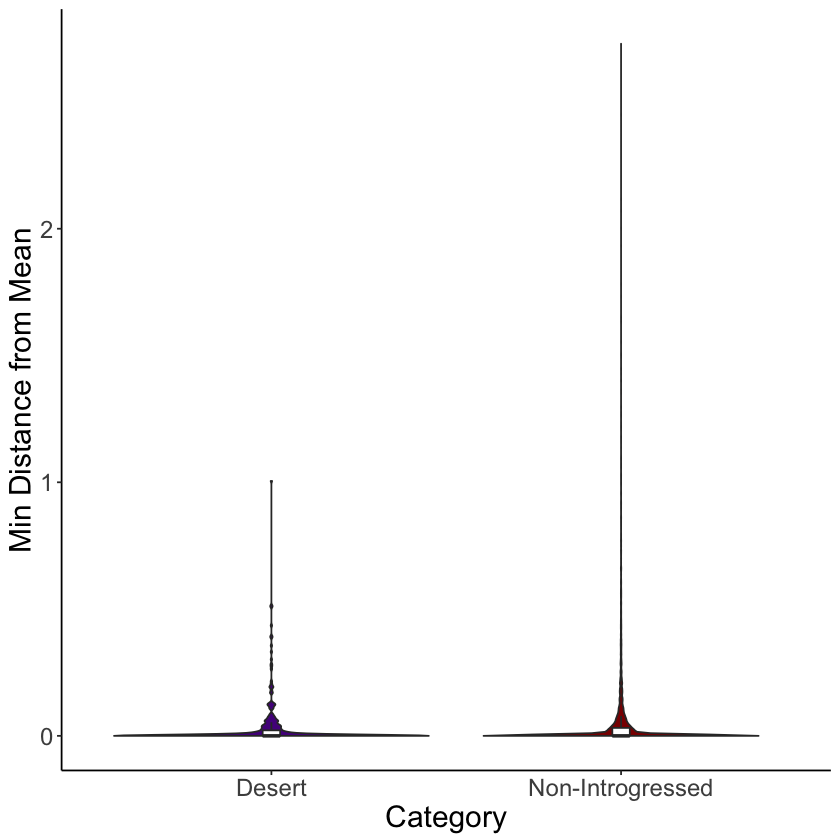

In [7]:
desert_file <- "data/altai_desert_genes.txt"
intro_file <- "data/altai_intro_genes.txt"
excl_file <- "data/altai_original_missingModels.txt"
pred_file <- "data/altai_original_predExp.txt"

desert_genes <- read_delim(desert_file,"\t", escape_double = FALSE, col_names = FALSE, trim_ws = TRUE)
intro_genes <- read_delim(intro_file,"\t", escape_double = FALSE, col_names = FALSE, trim_ws = TRUE)
excl_genes <- read_delim(excl_file,"\t", escape_double = FALSE, col_names = FALSE, trim_ws = TRUE)
altai_all <- read_delim(pred_file, "\t", escape_double = FALSE, trim_ws = TRUE)

for (i in 1:nrow(intro_genes)) {
    intro_genes[i,1] <- strsplit(intro_genes[i,1][[1]],"[.]")[[1]][1]
}
for (i in 1:nrow(desert_genes)) {
    desert_genes[i,1] <- strsplit(desert_genes[i,1][[1]],"[.]")[[1]][1]
}
for (i in 1:nrow(altai_all)) {
    altai_all[i,1] <- strsplit(altai_all[i,1][[1]],"[.]")[[1]][1]
}
for (i in 1:nrow(excl_genes)) {
    excl_genes[i,1] <- strsplit(excl_genes[i,1][[1]],"[.]")[[1]][1]
}

all_genes <- data.frame(X1 =altai_all$gene_id)
all_genes <- anti_join(all_genes,excl_genes)
desert_genes <- anti_join(desert_genes,excl_genes)
intro_genes <- anti_join(intro_genes,excl_genes)
desert_genes <- anti_join(desert_genes,intro_genes)

rows_to_remove <- c()
for (i in 1:nrow(all_genes)) {
    if (all_genes$X1[i] %in% desert_genes$X1 || all_genes$X1[i] %in% intro_genes$X1) {
      rows_to_remove <- c(rows_to_remove,i)
    }
}
control_genes <- data.frame(gene_id = all_genes[-rows_to_remove,])
desert_genes$gene_id <- desert_genes$X1
desert_genes$X1 <- NULL
remove(all_genes)

altai_all$count <- ncol(altai_all)-1
altai_all$mean <-  0
altai_all$max <- 0
altai_all$min <- 100
for (i in 2:(ncol(altai_all)-4)) {
    for (j in 1:nrow(altai_all)) {
      if (is.na(altai_all[j,i])) {
        altai_all$count[j] <- altai_all$count[j] -1
      } else {
        altai_all$mean[j] <- altai_all$mean[j] + abs(altai_all[j,i][[1]])
        if (abs(altai_all[j,i][[1]]) > altai_all$max[j]) { altai_all$max[j] <- abs(altai_all[j,i][[1]])}
        if (abs(altai_all[j,i][[1]])< altai_all$min[j]) {altai_all$min[j] <- abs(altai_all[j,i][[1]])}
      }
    }
}
altai_all$mean <- altai_all$mean/altai_all$count
altai_all$count <- NULL
desert_genes <- inner_join(altai_all,desert_genes)
control_genes <- inner_join(altai_all,control_genes)
remove(altai_all)

p_desert <- c()
mean_desert <- c()
mean_control <- c()
n <- c()
for (col in 2:(ncol(control_genes)-3)) {
    tmp <- data.frame(Expression = c(control_genes[,col][[1]],desert_genes[,col][[1]]),
                      Category = c(rep("Non-Introgressed",nrow(control_genes)), rep("Desert", nrow(desert_genes))))
    n <- c(n,names(control_genes)[col])
    #print(names(control_genes)[col])
    #print("Non-Intro Mean = ")
    #print(mean(abs(tmp[tmp$Category == "Non-Intro",]$Expression), na.rm = T))
    mean_control <- c(mean_control,mean(abs(tmp[tmp$Category == "Non-Introgressed",]$Expression), na.rm = T))
    new <- wilcox.test(abs(tmp[tmp$Category == "Desert",]$Expression), abs(tmp[tmp$Category == "Non-Introgressed",]$Expression))$p.value
    p_desert <- c(p_desert,new)
    #print("Desert mean = ")
    #print(mean(abs(tmp[tmp$Category == "Desert",]$Expression), na.rm = T))
    mean_desert <- c(mean_desert,mean(abs(tmp[tmp$Category == "Desert",]$Expression), na.rm = T))
    #print("p = ")
    #print(new)
}
remove(tmp)
p_values <- data.frame(Tissue = n,control_mean = mean_control,desert_mean = mean_desert,desert_p = p_desert)
p_values <- p_values[order(p_values$desert_p),]
p_values$desert_fdr <- "FAIL"
for (i in 1:nrow(p_values)) {
    p_values$desert_q[i] <- i*0.05/nrow(p_values)
    if (p_values$desert_p[i] < p_values$desert_q[i]) {p_values$desert_fdr[i] <- "PASS"}
}

means <- data.frame(tissue = rep(p_values$Tissue,2), mean = c(p_values$control_mean,p_values$desert_mean),
                  Category = c(rep("Non-Introgressed",nrow(p_values)), rep("Desert", nrow(p_values))))
for (i in 1:nrow(means)) {
    means$abb[i] <- abbreviations[as.character(means$tissue[i])]
}
ggplot(means,aes(x=abb,y=mean,color=Category)) + geom_point() + ylim(0,1.5) + theme_classic() + 
scale_colour_manual(values=c("purple4","darkred"))+
labs(x="Tissues",y="Genes Mean Expr.") + theme(text = element_text(size=14),axis.title.x= element_text(size = 24),axis.text.x=element_text(angle = 90,
                                                                                                  vjust = 0.5, hjust=1),axis.title.y=element_text(size = 24))

plots <- data.frame(Mean = c(control_genes$mean,desert_genes$mean), Max = c(control_genes$max,desert_genes$max),
                  Min = c(control_genes$min,desert_genes$min),
                  Category = c(rep("Non-Introgressed",nrow(control_genes)), rep("Desert", nrow(desert_genes))))

"Desert Mean:"
wilcox.test(plots[plots$Category == "Desert",]$Mean,plots[plots$Category == "Non-Introgressed",]$Mean)$p.value
"Desert Max:"
wilcox.test(plots[plots$Category == "Desert",]$Max,plots[plots$Category == "Non-Introgressed",]$Max)$p.value
"Desert Min:"
wilcox.test(plots[plots$Category == "Desert",]$Min,plots[plots$Category == "Non-Introgressed",]$Min)$p.value
ggplot(plots,aes(x=Category,y=Mean,fill=Category)) + geom_violin()+ geom_boxplot(width=0.05,fill="white",outlier.shape=NA) + 
    theme_classic() + scale_fill_manual(values=c("purple4","darkred"))+coord_cartesian(ylim=c(0,1))+
    labs(y="Mean Distance from Mean") + theme(text = element_text(size=18),legend.position = "none")##considering anything >1 as outlier
ggsave('mean_expr.pdf', width=6, height= 4) 
ggplot(plots,aes(x=Category,y=Max,fill=Category)) + geom_violin()+ geom_boxplot(width=0.05,fill="white",outlier.shape=NA) + 
    theme_classic() + scale_fill_manual(values=c("purple4","darkred"))+ coord_cartesian(ylim=c(0,4))+
    labs(y="Max Distance from Mean") +theme(text = element_text(size=18),legend.position = "none")##considering anything >4 as outlier
ggsave('max_expr.pdf', width=6, height= 4) 
ggplot(plots,aes(x=Category,y=Min,fill=Category)) + geom_violin()+ geom_boxplot(width=0.05,fill="white",outlier.shape=NA) + 
    theme_classic() + scale_fill_manual(values=c("purple4","darkred"))+
    labs(y="Min Distance from Mean") +theme(text = element_text(size=18),legend.position = "none")
ggsave('min_expr.pdf', width=6, height= 4) 

#### DR Odds ratio

In [5]:
desert_file <- "../data/altai_desert_genes.txt"
intro_file <- "../data/altai_intro_genes.txt"
excl_file <- "../data/altai_original_missingModels.txt"
pred_file <- "../data/altai_original_pvalues_2sided.txt"

desert_genes <- read_delim(desert_file,"\t", escape_double = FALSE, col_names = FALSE, trim_ws = TRUE)
intro_genes <- read_delim(intro_file,"\t", escape_double = FALSE, col_names = FALSE, trim_ws = TRUE)
excl_genes <- read_delim(excl_file,"\t", escape_double = FALSE, col_names = FALSE, trim_ws = TRUE)
altai_all <- read_delim(pred_file, "\t", escape_double = FALSE, trim_ws = TRUE)

for (i in 1:nrow(intro_genes)) {
    intro_genes[i,1] <- strsplit(intro_genes[i,1][[1]],"[.]")[[1]][1]
}
for (i in 1:nrow(desert_genes)) {
    desert_genes[i,1] <- strsplit(desert_genes[i,1][[1]],"[.]")[[1]][1]
}
for (i in 1:nrow(altai_all)) {
    altai_all[i,1] <- strsplit(altai_all[i,1][[1]],"[.]")[[1]][1]
}
for (i in 1:nrow(excl_genes)) {
    excl_genes[i,1] <- strsplit(excl_genes[i,1][[1]],"[.]")[[1]][1]
}

all_genes <- data.frame(X1 =altai_all$gene_id)
all_genes <- anti_join(all_genes,excl_genes)
desert_genes <- anti_join(desert_genes,excl_genes)
intro_genes <- anti_join(intro_genes,excl_genes)
desert_genes <- anti_join(desert_genes,intro_genes)

rows_to_remove <- c()
for (i in 1:nrow(all_genes)) {
    if (all_genes$X1[i] %in% desert_genes$X1 || all_genes$X1[i] %in% intro_genes$X1) {
      rows_to_remove <- c(rows_to_remove,i)
    }
}
control_genes <- data.frame(gene_id = all_genes[-rows_to_remove,])
desert_genes$gene_id <- desert_genes$X1
desert_genes$X1 <- NULL
remove(all_genes)

desert_genes <- inner_join(altai_all,desert_genes)
control_genes <- inner_join(altai_all,control_genes)

des_DR <- 0
cont_DR <- 0

# counting the genes in each category that are DR in any tissue
for (i in 1:(nrow(control_genes))) {
    if (0.0 %in% desert_genes[i,]) {
        des_DR <- des_DR + 1
    }
    if (0.0 %in% control_genes[i,]) {
        cont_DR <- cont_DR + 1
    }
}

des_norm <- nrow(desert_genes) - des_DR
cont_norm <- nrow(control_genes) - cont_DR

or <- oddsratio(des_DR,cont_DR,des_norm,cont_norm)
or

Parsed with column specification:
cols(
  X1 = col_character()
)
Parsed with column specification:
cols(
  X1 = col_character()
)
Parsed with column specification:
cols(
  X1 = col_character()
)
Parsed with column specification:
cols(
  .default = col_double(),
  gene_id = col_character()
)
See spec(...) for full column specifications.
Joining, by = "X1"
Warning message:
“Column `X1` joining factor and character vector, coercing into character vector”Joining, by = "X1"
Joining, by = "X1"
Joining, by = "X1"
Joining, by = "gene_id"
Joining, by = "gene_id"
Warning message:
“Column `gene_id` joining character vector and factor, coercing into character vector”

           Disease Nondisease Total
Exposed         27        313   340
Nonexposed    1305      11453 12758
Total         1332      11766 13098



	Odds ratio estimate and its significance probability

data:  des_DR cont_DR des_norm cont_norm
p-value = 0.1684
95 percent confidence interval:
 0.5088542 1.1263232
sample estimates:
[1] 0.7570563


Category,DRStatus,perc
Desert,DR,0.07941176
Non-Introgressed,DR,0.10228876
Desert,Non-DR,0.92058824
Non-Introgressed,Non-DR,0.89771124


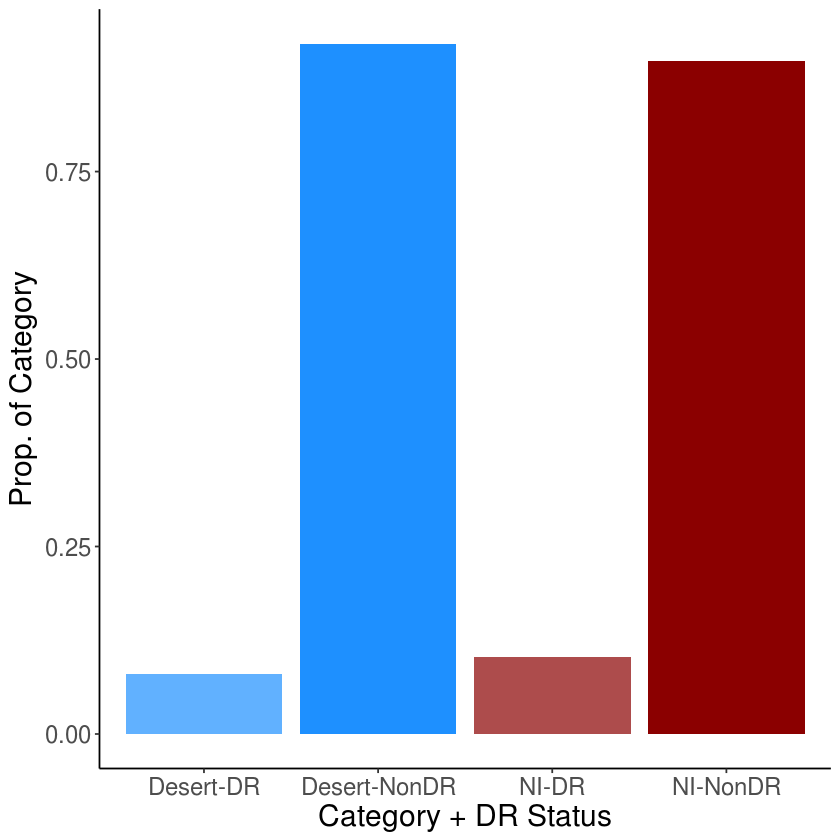

In [6]:
d <- data.frame(Category = c("Desert","Non-Introgressed","Desert","Non-Introgressed"),
                DRStatus = c("DR","DR","Non-DR","Non-DR"),
        perc = c(des_DR/nrow(desert_genes),cont_DR/nrow(control_genes),des_norm/nrow(desert_genes),cont_norm/nrow(control_genes)))
d

ggplot(d, aes(x=interaction(Category, DRStatus,lex.order=T), y=perc,fill=Category,alpha=DRStatus)) + geom_bar(stat = "identity",alpha=c(0.7,1,0.7,1))+ theme_classic() +
theme(text = element_text(size=18),legend.position = "none") +labs(y="Prop. of Category",x="Category + DR Status")+ scale_fill_manual(values=c("dodgerblue","darkred"))+
scale_x_discrete(labels=c("Desert-DR", "Desert-NonDR","NI-DR","NI-NonDR"))
ggsave('desert_DR_prop.pdf', width=6, height= 4) 

#### groups phenotypes and counts associations per group

Parsed with column specification:
cols(
  tissue = col_character(),
  phecode = col_character(),
  beta = col_double(),
  `p-value` = col_double(),
  gene = col_character(),
  trait = col_character(),
  r2 = col_double(),
  `no of cases` = col_integer(),
  `no of controls` = col_integer()
)


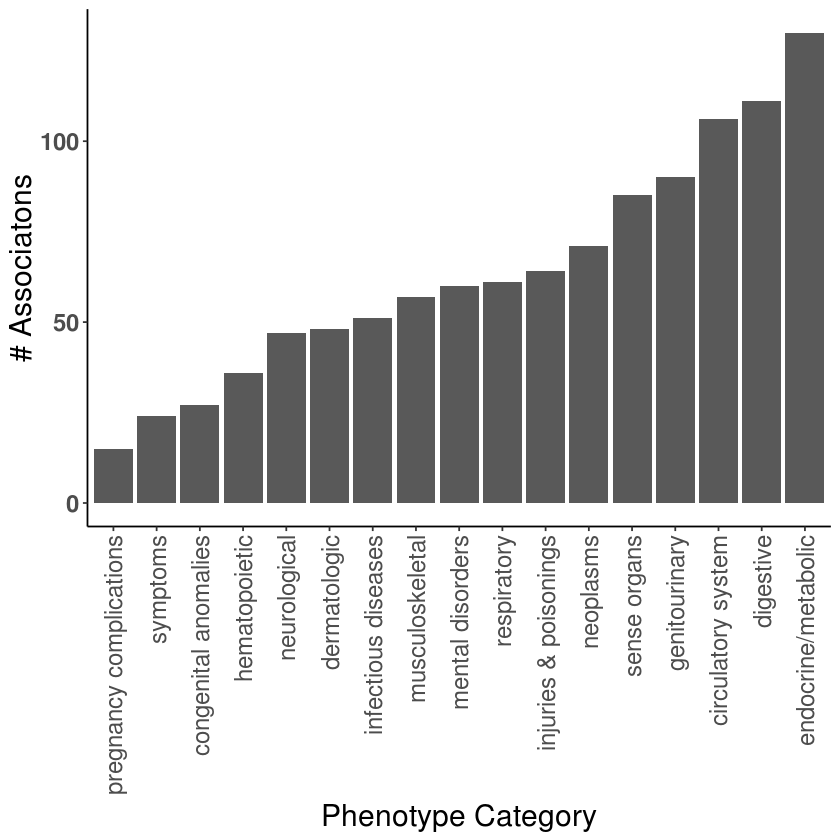

In [11]:
top_genes <- "../altai_dr_phewas.txt"

full_assoc_nean <- read_delim(top_genes, "\t", escape_double = FALSE, trim_ws = TRUE)
data(pheinfo)
full_assoc_nean$group <- "none"
full_assoc_nean <- full_assoc_nean[((full_assoc_nean$`p-value` < 0.00001) & (full_assoc_nean$`p-value` > 0)),]
for (row in 1:nrow(pheinfo)) {
    phecode <- pheinfo$phecode[row]
    if (startsWith(phecode, "00")) {phecode <- substr(phecode,3,nchar(phecode))}
    if (startsWith(phecode, "0")) {phecode <- substr(phecode,2,nchar(phecode))}
    if (paste("X",phecode,sep="") %in% full_assoc_nean$phecode) {
      full_assoc_nean[full_assoc_nean$phecode == paste("X",phecode,sep=""),]$group <- pheinfo$group[row]
    }
}
full_assoc_nean$sum <- 1
counts <- full_assoc_nean %>% group_by(group) %>% summarise(sum = sum(sum))
counts$t_sum <- 0
for (row in 1:nrow(counts)) {
    counts$t_sum[row] <- nrow(pheinfo[pheinfo$group == counts$group[row],])
}
counts$prop <- counts$sum/counts$t_sum
ggplot(counts,aes(x=reorder(group,sum),y=sum)) + ylab("# Associatons") + xlab("Phenotype Category") + theme_classic() + 
theme(legend.position = "none",text = element_text(size=18),axis.text.x = element_text(angle = 90,vjust=0.5,
           hjust=1),axis.text.y = element_text(face = "bold")) + geom_bar(stat="identity")
ggsave('phewas_counts.pdf', width=6, height= 6) 

#### Odds Ratios for DR genes being associated with a particular phenotype group

Parsed with column specification:
cols(
  tissue = col_character(),
  phecode = col_character(),
  beta = col_double(),
  `p-value` = col_double(),
  gene = col_character(),
  trait = col_character(),
  r2 = col_double(),
  `no of cases` = col_integer(),
  `no of controls` = col_integer()
)
Parsed with column specification:
cols(
  tissue = col_character(),
  phecode = col_character(),
  beta = col_double(),
  `p-value` = col_double(),
  gene = col_character(),
  trait = col_character(),
  r2 = col_double(),
  `no of cases` = col_integer(),
  `no of controls` = col_integer()
)
Parsed with column specification:
cols(
  `#names` = col_character()
)
Joining, by = "gene"
Joining, by = "gene"


           Disease Nondisease Total
Exposed         27        568   595
Nonexposed     229       5549  5778
Total          256       6117  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         27        568   595
Nonexposed     229       5549  5778
Total          256       6117  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         34        561   595
Nonexposed     391       5387  5778
Total          425       5948  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         34        561   595
Nonexposed     391       5387  5778
Total          425       5948  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         28        567   595
Nonexposed     377       5401  5778
Total          405       5968  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         28        567   595
Nonexposed     377       5401  5778
Total          405       5968  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         46        549   595
Nonexposed     453       5325  5778
Total          499       5874  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         46        549   595
Nonexposed     453       5325  5778
Total          499       5874  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         53        542   595
Nonexposed     448       5330  5778
Total          501       5872  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         53        542   595
Nonexposed     448       5330  5778
Total          501       5872  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         64        531   595
Nonexposed     602       5176  5778
Total          666       5707  6373


Warning message in N1 * N0 * M1:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         64        531   595
Nonexposed     602       5176  5778
Total          666       5707  6373


Warning message in N1 * N0 * M1:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         54        541   595
Nonexposed     427       5351  5778
Total          481       5892  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         54        541   595
Nonexposed     427       5351  5778
Total          481       5892  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         29        566   595
Nonexposed     274       5504  5778
Total          303       6070  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         29        566   595
Nonexposed     274       5504  5778
Total          303       6070  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         12        583   595
Nonexposed     183       5595  5778
Total          195       6178  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         12        583   595
Nonexposed     183       5595  5778
Total          195       6178  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         81        514   595
Nonexposed     773       5005  5778
Total          854       5519  6373


Warning message in N1 * N0 * M1:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         81        514   595
Nonexposed     773       5005  5778
Total          854       5519  6373


Warning message in N1 * N0 * M1:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         20        575   595
Nonexposed     254       5524  5778
Total          274       6099  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         20        575   595
Nonexposed     254       5524  5778
Total          274       6099  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         31        564   595
Nonexposed     358       5420  5778
Total          389       5984  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         31        564   595
Nonexposed     358       5420  5778
Total          389       5984  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed          4        591   595
Nonexposed      84       5694  5778
Total           88       6285  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed          4        591   595
Nonexposed      84       5694  5778
Total           88       6285  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         49        546   595
Nonexposed     444       5334  5778
Total          493       5880  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         49        546   595
Nonexposed     444       5334  5778
Total          493       5880  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         36        559   595
Nonexposed     207       5571  5778
Total          243       6130  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         36        559   595
Nonexposed     207       5571  5778
Total          243       6130  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed          9        586   595
Nonexposed     132       5646  5778
Total          141       6232  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed          9        586   595
Nonexposed     132       5646  5778
Total          141       6232  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         18        577   595
Nonexposed     142       5636  5778
Total          160       6213  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”

           Disease Nondisease Total
Exposed         18        577   595
Nonexposed     142       5636  5778
Total          160       6213  6373


Warning message in N1 * N0 * M1 * M0:
“NAs produced by integer overflow”



|phenotypes              |        ors| pvalue|        low|      high|
|:-----------------------|----------:|------:|----------:|---------:|
|infectious diseases     |  0.1413665|     NA| -0.2666932| 0.5494261|
|injuries & poisonings   | -0.1803240|     NA| -0.5413977| 0.1807497|
|respiratory             | -0.3460606|     NA| -0.7396041| 0.0474829|
|neoplasms               | -0.0151812|     NA| -0.3309537| 0.3005913|
|sense organs            |  0.1513392|     NA| -0.1467658| 0.4494442|
|digestive               |  0.0356515|     NA| -0.2370815| 0.3083844|
|genitourinary           |  0.2238195|     NA| -0.0727548| 0.5203938|
|dermatologic            |  0.0288040|     NA| -0.3635920| 0.4212001|
|symptoms                | -0.4631381|     NA| -1.0533937| 0.1271175|
|endocrine/metabolic     |  0.0201395|     NA| -0.2261091| 0.2663881|
|neurological            | -0.2791145|     NA| -0.7423433| 0.1841142|
|musculoskeletal         | -0.1837489|     NA| -0.5608079| 0.1933100|
|pregnancy complic

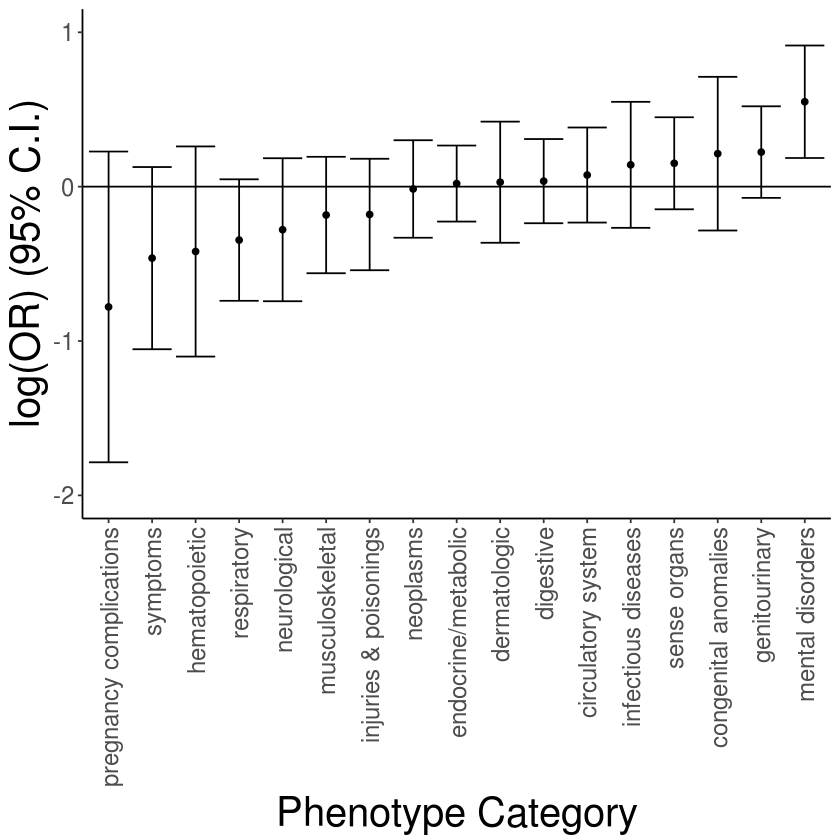

In [7]:
top_genes <- "../altai_dr_phewas.txt"
control <- "../nonIntro_nonDR_Allgenes_phewas.txt"

data(pheinfo)
full_assoc_nean <- read_delim(top_genes, "\t", escape_double = FALSE, trim_ws = TRUE)
full_control <- read_delim(control, "\t", escape_double = FALSE, trim_ws = TRUE)

## if filtering by introgression status of genes:
intro_genes <- read_csv("../data/altai_intro_genes_names.txt")
intro_genes$gene <- intro_genes$`#names`
intro_genes$`#names` <- NULL

# get introgressed genes
#full_assoc_nean <- inner_join(full_assoc_nean, intro_genes)
#full_control <- inner_join(full_control, intro_genes)
# get non-Introgressed genes
full_assoc_nean <- anti_join(full_assoc_nean, intro_genes)
full_control <- anti_join(full_control, intro_genes)

full_assoc_nean$group <- "none"
full_assoc_nean <- full_assoc_nean[((full_assoc_nean$`p-value` < 0.00001) & (full_assoc_nean$`p-value` > 0)),]
full_control$group <- "none"
full_control <- full_control[((full_control$`p-value` < 0.00001) & (full_control$`p-value` > 0)),]
for (row in 1:nrow(pheinfo)) {
    phecode <- pheinfo$phecode[row]
    if (startsWith(phecode, "00")) {phecode <- substr(phecode,3,nchar(phecode))}
    if (startsWith(phecode, "0")) {phecode <- substr(phecode,2,nchar(phecode))}
    if (paste("X",phecode,sep="") %in% full_control$phecode) {
      full_control[full_control$phecode == paste("X",phecode,sep=""),]$group <- pheinfo$group[row]
    }
    if (paste("X",phecode,sep="") %in% full_assoc_nean$phecode) {
      full_assoc_nean[full_assoc_nean$phecode == paste("X",phecode,sep=""),]$group <- pheinfo$group[row]
    }
}
ORs <- data.frame(phenotypes = unique(full_assoc_nean$group), ors = 0)
for (row in 1:nrow(ORs)) {
    phen_nean <- nrow(full_assoc_nean[full_assoc_nean$group == ORs$phenotypes[row],])
    phen_control <- nrow(full_control[full_control$group == ORs$phenotypes[row],])
    norm_nean <- nrow(full_assoc_nean[full_assoc_nean$group != ORs$phenotypes[row],])
    norm_control <- nrow(full_control[full_control$group != ORs$phenotypes[row],])
    ORs$ors[row] <- log(oddsratio(phen_nean,phen_control,norm_nean,norm_control)$estimate)
    ORs$pvalue[row] <- oddsratio(phen_nean,phen_control,norm_nean,norm_control)$p.value
    ORs$low[row] <- ORs$ors[row]-1.96*sqrt((1/phen_nean)+(1/phen_control)+(1/norm_nean)+(1/norm_control))
    ORs$high[row] <- ORs$ors[row]+1.96*sqrt((1/phen_nean)+(1/phen_control)+(1/norm_nean)+(1/norm_control))
}
ggplot(ORs,aes(x=reorder(phenotypes,ors),y=ors)) + geom_point() + theme_classic() +
    theme(text = element_text(size=18),axis.title.x= element_text(size = 24),axis.text.x=element_text(angle = 90,vjust = 0.5,hjust=1),axis.title.y=element_text(size = 24)) + geom_errorbar(aes(ymin = low,ymax = high)) + 
    geom_hline(yintercept=0,color = "black")+ xlab("Phenotype Category") + ylab("log(OR) (95% C.I.)") +ylim(-2,1)
ggsave('../phewas_ors.pdf', width=6, height= 6) 
kable(ORs)

#### Counts of Derived SNPs

Parsed with column specification:
cols(
  X1 = col_character()
)
Parsed with column specification:
cols(
  X1 = col_character()
)
Parsed with column specification:
cols(
  X1 = col_character()
)
Parsed with column specification:
cols(
  `#gene` = col_character(),
  snp_count = col_integer()
)
Warning message:
“Unknown or uninitialised column: '#gene'.”Warning message:
“Unknown or uninitialised column: '#gene'.”

[1] 179.7807

[1] 141.9139

[1] 144.3651

[1] 9.23779e-19

[1] 1.02252e-15

Warning message:
“Removed 28 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 28 rows containing non-finite values (stat_boxplot).”

Warning message:
“Removed 28 rows containing non-finite values (stat_ydensity).”Warning message:
“Removed 28 rows containing non-finite values (stat_boxplot).”

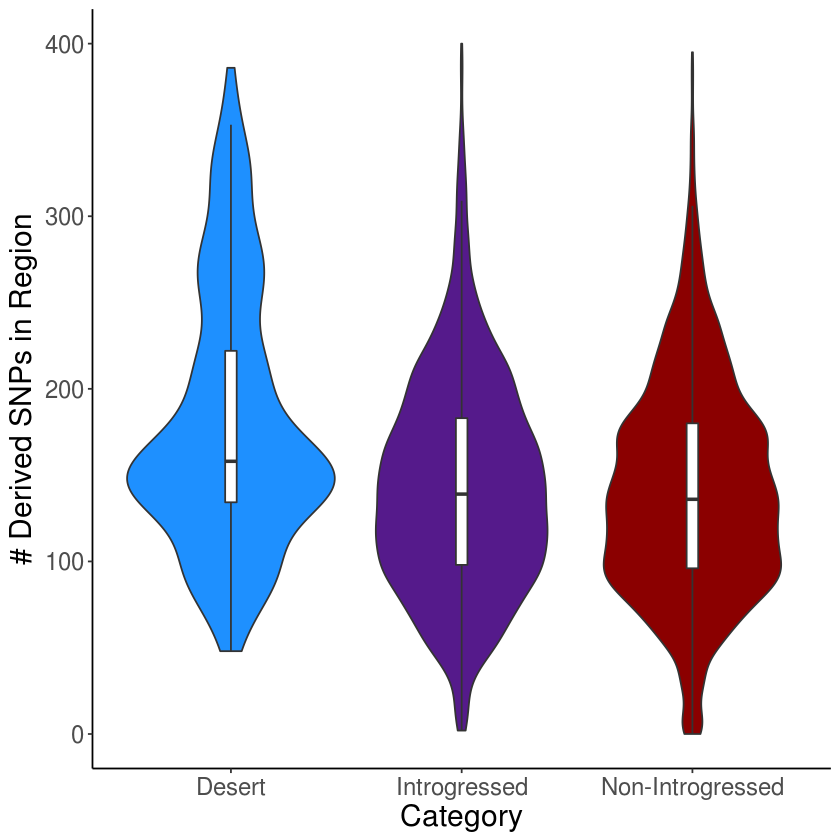

In [3]:
der_file <- "../data/gene-dersnp_intersection.txt"
desert_file <- "../data/altai_desert_genes.txt"
intro_file <- "../data/altai_intro_genes.txt"
excl_file <- "../data/altai_original_missingModels.txt"

excl_genes <- read_delim(excl_file,"\t", escape_double = FALSE, col_names = FALSE, trim_ws = TRUE)
desert_genes <- read_delim(desert_file,"\t", escape_double = FALSE, col_names = FALSE, trim_ws = TRUE)
intro_genes <- read_delim(intro_file,"\t", escape_double = FALSE, col_names = FALSE, trim_ws = TRUE)
der_snps <- read_delim(der_file,"\t", escape_double = FALSE, col_names = TRUE, trim_ws = TRUE)

for (i in 1:nrow(desert_genes)) {
    desert_genes$`#gene`[i] <- strsplit(desert_genes$X1[i],"\\.")[[1]][1]
}
for (i in 1:nrow(intro_genes)) {
    intro_genes$`#gene`[i] <- strsplit(intro_genes$X1[i],"\\.")[[1]][1]
}
for (i in 1:nrow(excl_genes)) {
    excl_genes[i,1] <- strsplit(excl_genes[i,1][[1]],"[.]")[[1]][1]
}
excl_genes$`#gene` <- excl_genes$X1
excl_genes$X1 <- NULL
der_snps$Category <- "Non-Introgressed"
for (i in 1:nrow(der_snps)){
    if (der_snps$`#gene`[i] %in% intro_genes$`#gene`) {
        der_snps$Category[i] <- "Introgressed"
    }else {if(der_snps$`#gene`[i] %in% desert_genes$`#gene`) {
        der_snps$Category[i] <- "Desert"
    }}
}
#der_snps <- anti_join(der_snps,excl_genes)

mean(der_snps[der_snps$Category == "Desert",]$snp_count)
mean(der_snps[der_snps$Category == "Non-Introgressed",]$snp_count)
mean(der_snps[der_snps$Category == "Introgressed",]$snp_count)
wilcox.test(der_snps[der_snps$Category == "Desert",]$snp_count,der_snps[der_snps$Category == "Non-Introgressed",]$snp_count)$p.value
wilcox.test(der_snps[der_snps$Category == "Desert",]$snp_count,der_snps[der_snps$Category == "Introgressed",]$snp_count)$p.value

ggplot(der_snps,aes(x=Category,y=snp_count,fill=Category)) + geom_violin()+
  geom_boxplot(width=0.05,fill="white",outlier.shape=NA) +theme_classic() + scale_fill_manual(values=c("dodgerblue","purple4","darkred"))+
labs(y="# Derived SNPs in Region") +theme(text = element_text(size=18),legend.position = "none")+ylim(0,400)#considering everything > 400 outlier
ggsave('der_snps.pdf', width=6, height= 4) 

#### Plot GO associations

Parsed with column specification:
cols(
  geneset = col_character(),
  description = col_character(),
  link = col_character(),
  C = col_integer(),
  O = col_integer(),
  E = col_double(),
  R = col_double(),
  PValue = col_double(),
  FDR = col_double(),
  overlapGene = col_character(),
  OverlapGene_UserID = col_character()
)


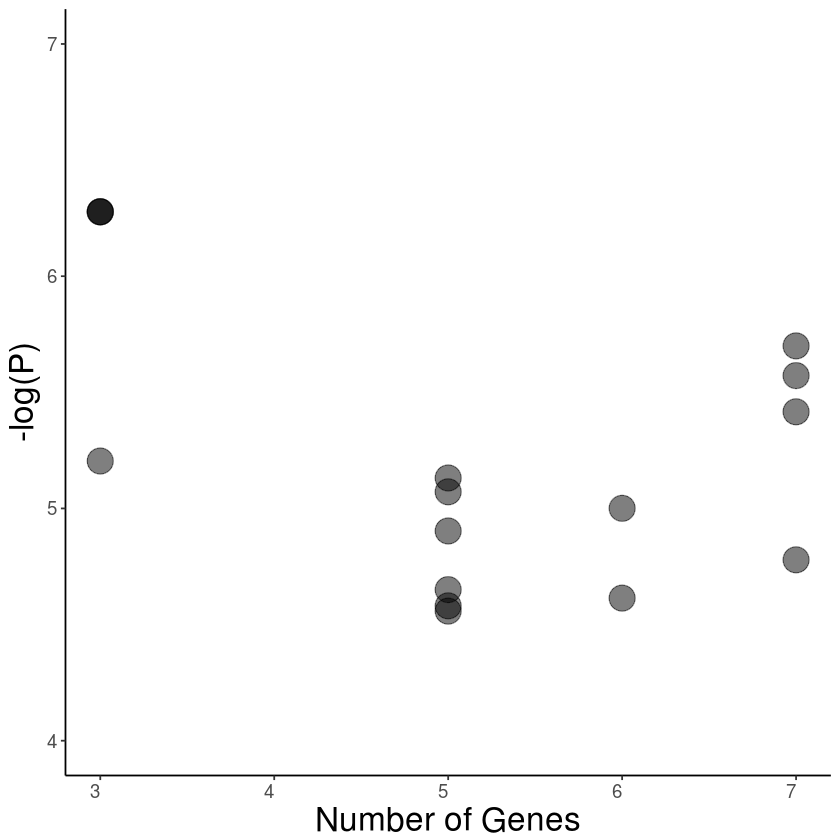

In [30]:
enr_file <- "species_diff_GO/altVindenrichment_results.txt"

enrichments <- read_delim(enr_file,"\t", escape_double = FALSE, col_names = TRUE, trim_ws = TRUE)
enrichments$logp <- log(enrichments$PValue,base=10)
ggplot(enrichments[enrichments$FDR < 0.05,],aes(x=O,y=-logp)) + geom_point(alpha=0.5,size=7) + theme_classic() + 
labs(x="Number of Genes",y="-log(P)") + theme(text = element_text(size=14),axis.title.x= element_text(size = 20),
                axis.text.x=element_text(vjust = 0.5, hjust=1),axis.title.y=element_text(size = 20))+ylim(4,7)
ggsave('GO_plot.pdf', width=6, height= 4) 

#### Plot Desert Genes on chromosomes

pdf 
  3

pdf 
  2

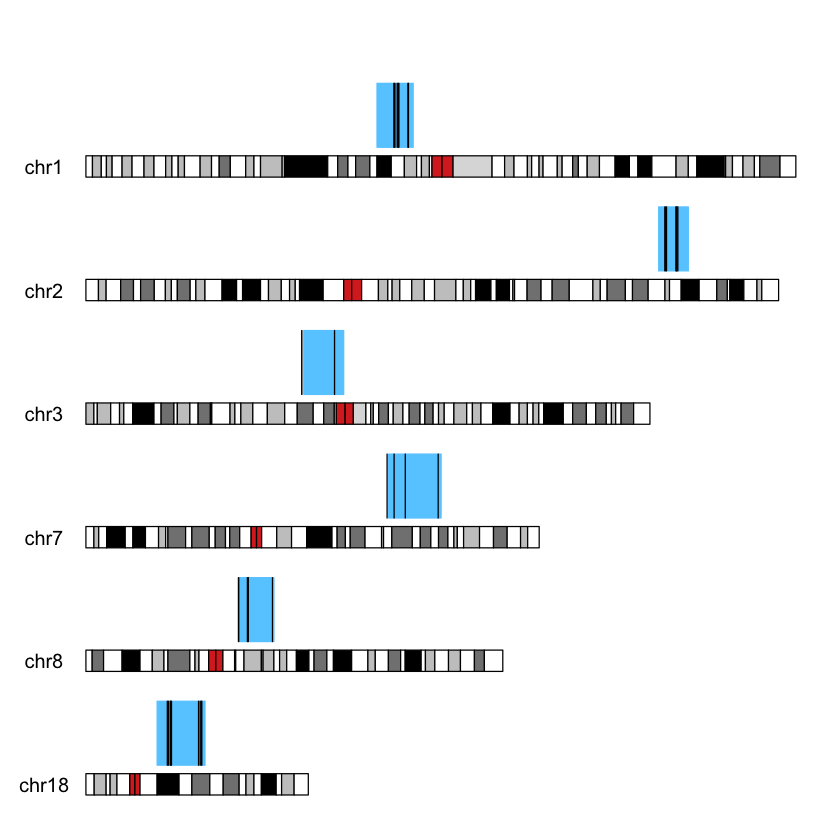

In [5]:
gene_file <- "~/Dropbox (VU Basic Sciences)/predixcan/results/introgression/desert_dr_genes.bed"
deserts <- "~/Dropbox (VU Basic Sciences)/predixcan/data/nean_deserts.bed"

dr_genes <- read.delim(gene_file, header=FALSE, stringsAsFactors=FALSE)
des <- read.delim(deserts, header=FALSE, stringsAsFactors=FALSE,comment.char = "#")
for (i in 1:nrow(dr_genes)){
    dr_genes$V1[i] <- paste("chr",dr_genes$V1[i],sep="")
}
for (i in 1:nrow(des)){
    des$V1[i] <- paste("chr",des$V1[i],sep="")
}

#chrms <- unique(dr_genes$V1))
chrms <- c("chr1","chr2","chr3","chr7","chr8","chr18")
genes <- makeGRangesFromDataFrame(data_frame(chr = dr_genes$V1, start=dr_genes$V2,end=dr_genes$V3))
deserts <- makeGRangesFromDataFrame(data_frame(chr = des$V1, start=des$V2,end=des$V3))
values(genes) <- DataFrame(names=c("ZDBF2","PIK3C3","VAV3","RB1CC1","CHMP2B","PSRC1","GAREM1","RIT2","STXBP3","BMPR2","ZNF717","THAP5","ADAM23","CELSR2","DSG3","TGS1","SYPL1","ST7L","TMEM229A","CPO","MOV10","CARF","LSMEM1","BHLHE22","MOS","RNF138","DSC3"))

kp <-plotKaryotype(genome="hg19", chromosomes=chrms)
#kpPlotMarkers(kp, data=genes,labels=genes$names,text.orientation = "vertical",
#              r1=0.5, cex=0.8,label.dist = .00001,  adjust.label.position = T)
kpPlotRegions(kp, deserts, col="#66ccff",r1=0.75)
kpPlotRegions(kp, data=genes,r1=0.75)
dev.copy(pdf,"desert_genes.pdf",width = 10, height = 3)
dev.off()

#### plot greyscale 1kG distribution of a gene

V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,⋯,V2496,V2497,V2498,V2499,V2500,V2501,V2502,V2503,V2504,V2505
-0.07605538,0.04079986,-0.06053698,-0.09210503,-0.07605538,-0.07599311,-0.01361751,0.01909958,0.1031132,-0.07605538,⋯,-0.1149543,-0.09769339,0.005633489,-0.1365924,-0.02163801,0.01909958,-0.01594225,-0.09769339,-0.07605538,-0.1076857


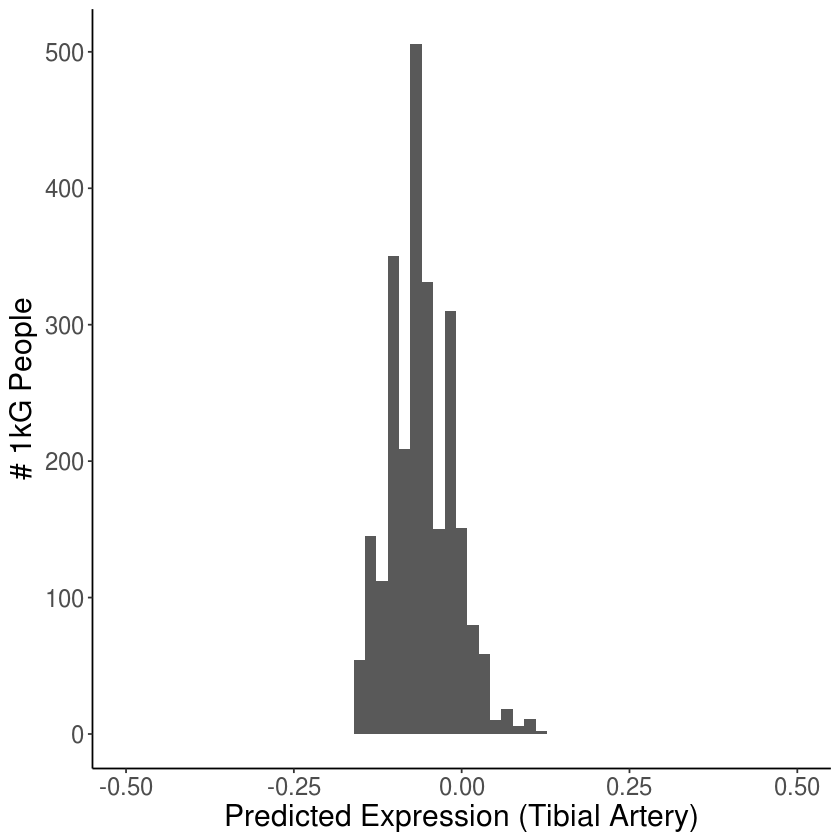

In [6]:
dist_path <- "~/Dropbox (VU Basic Sciences)/predixcan/results/exp_dist_1kG/zdbf2_tibArt.txt"
#dist_path <- "../cyp11a1_adiposeVO_dist.txt"

dist <- read.delim(dist_path,header =F, comment.char = '#')
dist$V1 <- NULL
dist
dist <- as.data.frame(t(dist))

ggplot(dist,aes(V1)) + geom_histogram(bins = 60) + xlab("Predicted Expression (Tibial Artery)") + ylab("# 1kG Individuals") + theme_classic() +
  theme(text = element_text(size=18),axis.title.x= element_text(size = 18),axis.title.y=element_text(size = 18)) +xlim(-0.5,0.5)
ggsave("dist_tibArt.pdf",width=5, height=4)

#### plot 1kG distribution of gene, colored by superpopulation

Joining, by = "X.Individual.ID"
Warning message:
“Column `X.Individual.ID` joining character vector and factor, coercing into character vector”

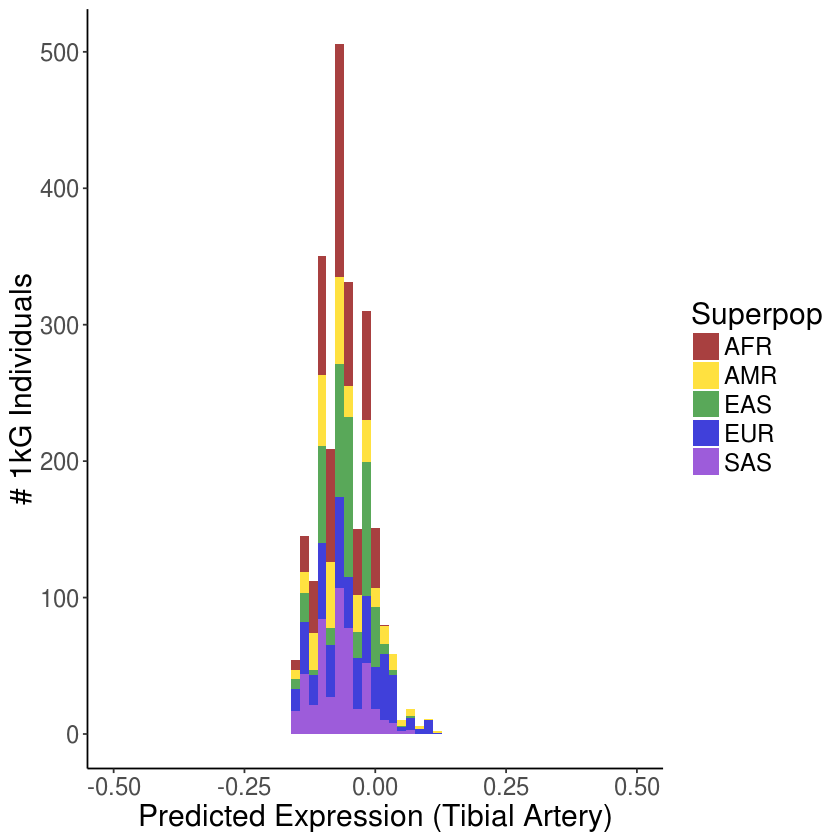

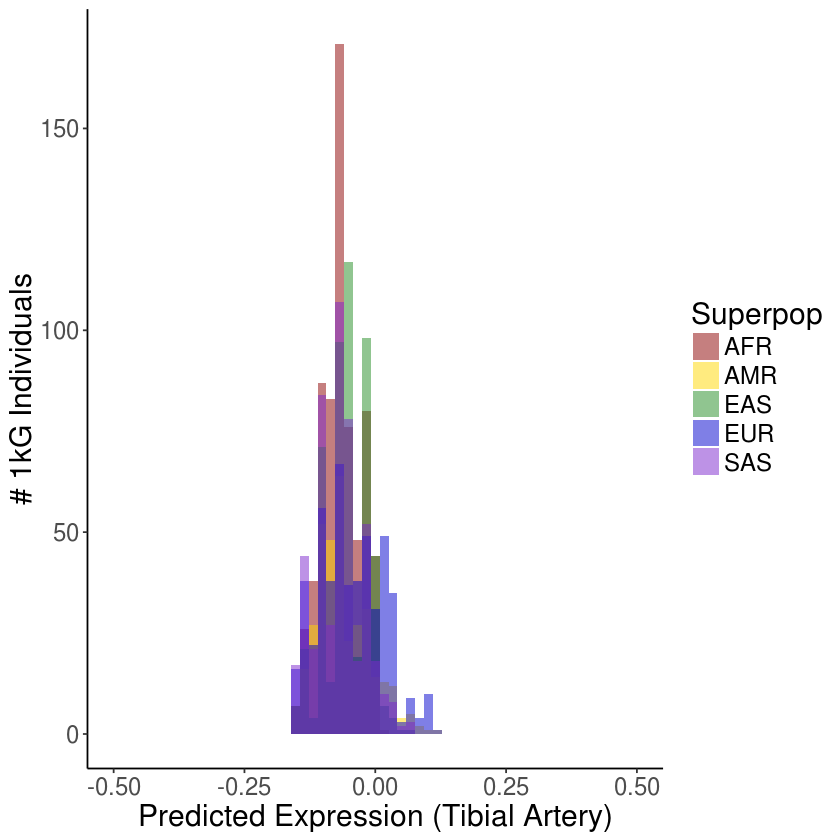

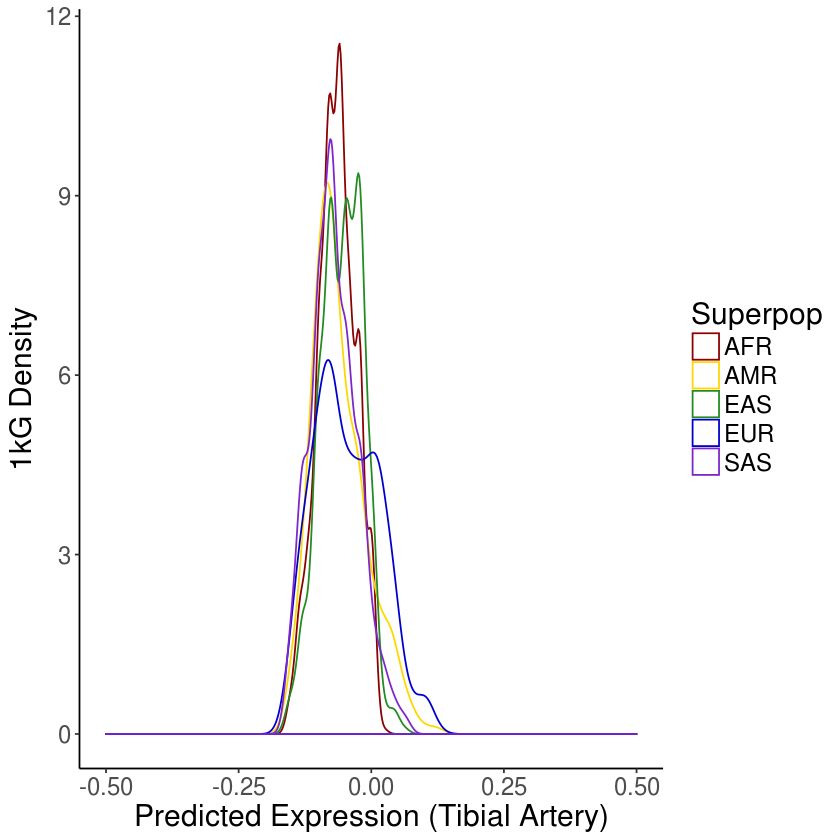

In [33]:
dist_path <- "~/Dropbox (VU Basic Sciences)/predixcan/results/exp_dist_1kG/zdbf2_tibArt.txt"
id_path <- "~/Dropbox (VU Basic Sciences)/predixcan/data/1kG_SuperPop_IDs.txt"

dist <- read.delim(dist_path,header =T)
dist$X.gene<- NULL
dist <- tibble::rownames_to_column(as.data.frame(t(dist)), "X.Individual.ID")

pop_ids <- read.delim(id_path,header =T)
dist <- inner_join(dist,pop_ids)

ggplot(dist,aes(V1)) + geom_histogram(bins = 60,aes(fill=Superpop),alpha=0.75) + xlab("Predicted Expression (Tibial Artery)") + ylab("# 1kG Individuals") +
  theme_classic() + scale_fill_manual(values=c("darkred","gold","forestgreen","mediumblue","purple3")) +
  theme(text = element_text(size=18),axis.title.x= element_text(size = 18),axis.title.y=element_text(size = 18)) +xlim(-0.5,0.5)
ggsave("dist_tibArt_pops_stacked.pdf",width=5, height=4)
ggplot(dist,aes(V1)) + geom_histogram(bins = 60,aes(fill=Superpop),alpha=0.5,position = 'identity') + xlab("Predicted Expression (Tibial Artery)") + ylab("# 1kG Individuals") +
  theme_classic() + scale_fill_manual(values=c("darkred","gold","forestgreen","mediumblue","purple3")) +
  theme(text = element_text(size=18),axis.title.x= element_text(size = 18),axis.title.y=element_text(size = 18)) +xlim(-0.5,0.5)
ggsave("dist_tibArt_pops_overlap.pdf",width=5, height=4)
ggplot(dist) +
  geom_density(aes(x=V1,colour=Superpop)) + xlab("Predicted Expression (Tibial Artery)") + ylab("1kG Density") +
  theme_classic() + scale_colour_manual(values=c("darkred","gold","forestgreen","mediumblue","purple3")) +
  theme(text = element_text(size=18),axis.title.x= element_text(size = 18),axis.title.y=element_text(size = 18)) +xlim(-0.5,0.5)
ggsave("dist_tibArt_pops_density.pdf",width=5, height=4)

#### predicted expression correlations between Altai genomes

In [49]:
original_path <- "data/altai_original_predExp.txt"
update_path <- "data/altai_update_predExp.txt"
excl1_path <- "data/altai_original_missingModels.txt"
excl2_path <- "data/altai_update_missingModels.txt"

orig_mat <- read_delim(original_path, "\t", escape_double = FALSE, trim_ws = TRUE)
upd_mat <- read_delim(update_path, "\t", escape_double = FALSE, trim_ws = TRUE)
excl1 <- read_delim(excl1_path,"\t", escape_double = FALSE, col_names = FALSE, trim_ws = TRUE)
excl2 <- read_delim(excl2_path,"\t", escape_double = FALSE, col_names = FALSE, trim_ws = TRUE)

excl1$gene_id <- excl1$X1
excl1$X1 <- NULL
excl2$gene_id <- excl2$X1
excl2$X1 <- NULL

orig_mat <- anti_join(anti_join(orig_mat,excl1),excl2)
upd_mat <- anti_join(anti_join(upd_mat,excl1),excl2)
out <- DataFrame(tissue = rep("nil",ncol(orig_mat)-1))
for (i in 2:ncol(orig_mat)) {
    out$tissue[i-1] <- names(orig_mat)[i]
    out$rho[i-1] <- cor.test(orig_mat[,i][[1]],upd_mat[,i][[1]],method = "spearman")$estimate
    out$p[i-1] <- cor.test(orig_mat[,i][[1]],upd_mat[,i][[1]],method = "spearman")$p.value
}
mean(out$rho)
kable(out)

Parsed with column specification:
cols(
  .default = col_double(),
  gene_id = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double(),
  gene_id = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  X1 = col_character()
)
Parsed with column specification:
cols(
  X1 = col_character()
)
Joining, by = "gene_id"
Joining, by = "gene_id"
Joining, by = "gene_id"
Joining, by = "gene_id"
Warning message in cor.test.default(orig_mat[, i][[1]], upd_mat[, i][[1]], method = "spearman"):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(orig_mat[, i][[1]], upd_mat[, i][[1]], method = "spearman"):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(orig_mat[, i][[1]], upd_mat[, i][[1]], method = "spearman"):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(orig_mat[, i][[1]], upd_mat[, i][[1]], me

"Cannot compute exact p-value with ties"Warning message in cor.test.default(orig_mat[, i][[1]], upd_mat[, i][[1]], method = "spearman"):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(orig_mat[, i][[1]], upd_mat[, i][[1]], method = "spearman"):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(orig_mat[, i][[1]], upd_mat[, i][[1]], method = "spearman"):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(orig_mat[, i][[1]], upd_mat[, i][[1]], method = "spearman"):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(orig_mat[, i][[1]], upd_mat[, i][[1]], method = "spearman"):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(orig_mat[, i][[1]], upd_mat[, i][[1]], method = "spearman"):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(orig_mat[, i][[1]], upd_mat[, i][[1]], method = "spearman"):
"Cannot compute exact p-value with ties"W

[1] 0.8117608



|tissue                                |       rho|  p|
|:-------------------------------------|---------:|--:|
|adipose_subcutaneous                  | 0.8354703|  0|
|esophagus_mucosa                      | 0.8324968|  0|
|adipose_visceral_omentum              | 0.8248803|  0|
|esophagus_muscularis                  | 0.8284796|  0|
|adrenal_gland                         | 0.8113760|  0|
|heart_atrial_appendage                | 0.8045131|  0|
|anterior_cingulate_cortex             | 0.7928536|  0|
|left_ventricle                        | 0.8110262|  0|
|artery_aorta                          | 0.8216417|  0|
|liver                                 | 0.7944327|  0|
|artery_coronary                       | 0.7950425|  0|
|lung                                  | 0.8267054|  0|
|artery_tibial                         | 0.8352358|  0|
|muscle_skeletal                       | 0.8300338|  0|
|brain_caudate_basal_ganglia           | 0.7862996|  0|
|nerve_tibial                          | 0.848

#### correlation between tissue sample size and DR genes

Joining, by = "V1"
Warning message:
“Column `V1` joining factors with different levels, coercing to character vector”Warning message in cor.test.default(dr_genes$count, dr_genes$V2, method = "spearman"):
“Cannot compute exact p-value with ties”


	Spearman's rank correlation rho

data:  dr_genes$count and dr_genes$V2
S = 1447.8, p-value = 1.272e-15
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.8906811 


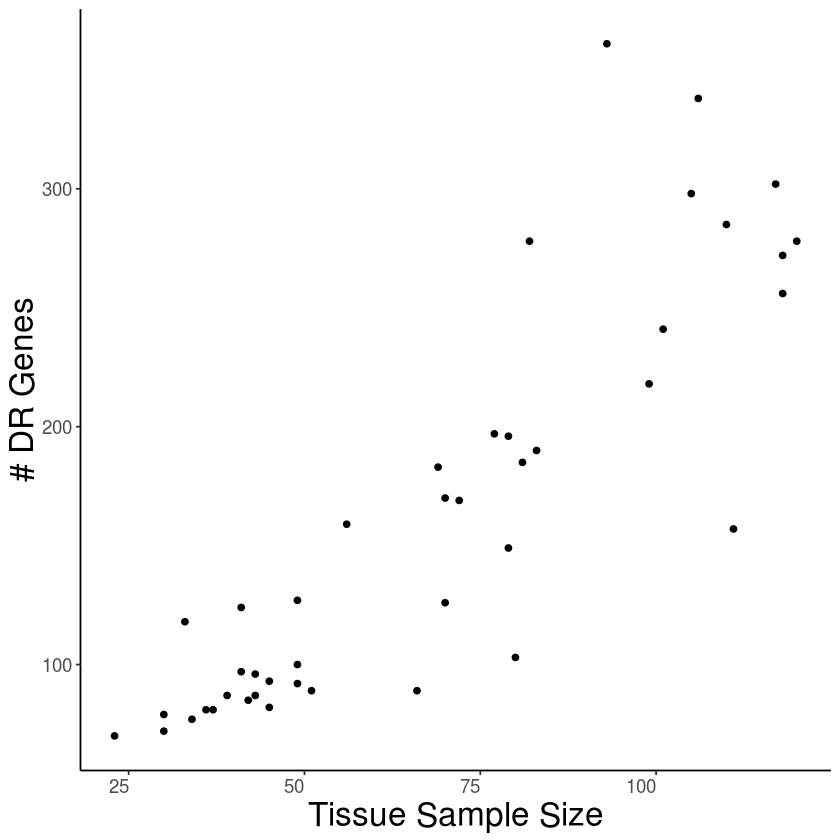

In [40]:
size_path <- "~/Dropbox (VU Basic Sciences)/predixcan/data/gtex_v6_sample_sizes.txt"
dr_path <- "~/Dropbox (VU Basic Sciences)/predixcan/results/altai_1kG_fixed/altai_1kG_fixed_p_values_2sided_tissues_top_genes.txt"

dr_genes <- read.delim(dr_path,header =F)
sample_size <- read.delim(size_path,header=F)

dr_genes$iter <- 1
dr_genes <- dr_genes %>% group_by(V1) %>% summarise(count = sum(iter))
dr_genes <- inner_join(dr_genes,sample_size)

cor.test(dr_genes$count,dr_genes$V2,method = "spearman")

ggplot(dr_genes,aes(x=count,y=V2)) + geom_point() + theme_classic() + 
labs(x="Tissue Sample Size",y="# DR Genes") + theme(text = element_text(size=14),axis.title.x= element_text(size = 20),
                axis.text.x=element_text(vjust = 0.5, hjust=1),axis.title.y=element_text(size = 20))
ggsave('sampleSize_drCount.pdf', width=6, height= 4) 